# Use pure numpy array

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xesmf as xe

## Rectilinear grid

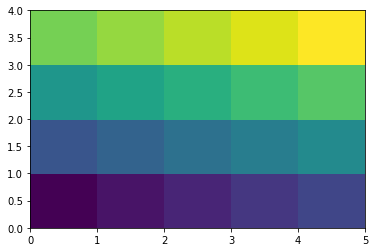

In [2]:
data = np.arange(20).reshape(4, 5)
plt.pcolormesh(data)

In [3]:
grid_in = {'lon': np.linspace(0, 40, 5),
           'lat': np.linspace(0, 20, 4)
          }

grid_out = {'lon': np.linspace(-20, 60, 15),
            'lat': np.linspace(-10, 30, 12)
          }

In [4]:
regridder = xe.Regridder(grid_in, grid_out, 'bilinear')
regridder.clean_weight_file()
regridder 

Create weight file: bilinear_4x5_12x15.nc
Remove file bilinear_4x5_12x15.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_4x5_12x15.nc 
Reuse pre-computed weights? False 
Input grid shape:           (4, 5) 
Output grid shape:          (12, 15) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [5]:
data_out = regridder(data)

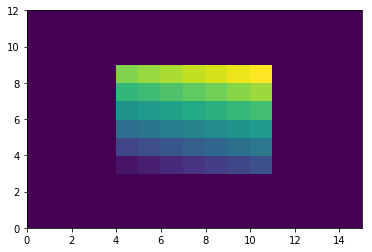

In [6]:
plt.pcolormesh(data_out)

## Curvilinear grid

http://xarray.pydata.org/en/stable/plotting.html#multidimensional-coordinates

In [7]:
lon, lat = np.meshgrid(np.linspace(-20, 20, 5), np.linspace(0, 30, 4))
lon += lat/3
lat += lon/3

lon_b, lat_b = np.meshgrid(np.linspace(-25, 25, 6), np.linspace(-5, 35, 5))
lon_b += lat_b/3
lat_b += lon_b/3

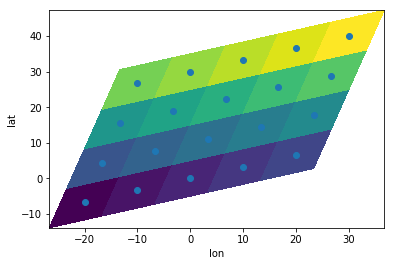

In [8]:
plt.pcolormesh(lon_b, lat_b, data)
plt.scatter(lon, lat)  # show cell center
plt.xlabel('lon')
plt.ylabel('lat')

In [9]:
lon_out_b = np.linspace(-30, 40, 51)
lon_out = 0.5*(lon_out_b[1:]+lon_out_b[:-1])

lat_out_b = np.linspace(-20, 50, 41)
lat_out = 0.5*(lat_out_b[1:]+lat_out_b[:-1])

In [10]:
grid_in = {'lon': lon, 'lat': lat,
           'lon_b': lon_b, 'lat_b': lat_b}

grid_out = {'lon': lon_out, 'lat': lat_out,
           'lon_b': lon_out_b, 'lat_b': lat_out_b}

regridder = xe.Regridder(grid_in, grid_out, 'conservative')
regridder.clean_weight_file()
regridder 

Create weight file: conservative_4x5_40x50.nc
Remove file conservative_4x5_40x50.nc


xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_4x5_40x50.nc 
Reuse pre-computed weights? False 
Input grid shape:           (4, 5) 
Output grid shape:          (40, 50) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [11]:
data_out = regridder(data)

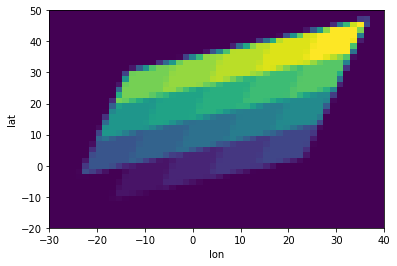

In [12]:
plt.pcolormesh(lon_out_b, lat_out_b, data_out)
plt.xlabel('lon')
plt.ylabel('lat')